# AV Hackathon : Time Series Forecasting

## Problem Statement
Unicorn Investors wants to make an investment in a new form of transportation - JetRail. JetRail uses Jet propulsion technology to run rails and move people at a high speed! While JetRail has mastered the technology and they hold the patent for their product, the investment would only make sense, if they can get more than 1 Million monthly users with in next 18 months.
 
You need to help Unicorn ventures with the decision. They usually invest in B2C start-ups less than 4 years old looking for pre-series A funding. In order to help Unicorn Ventures in their decision, you need to forecast the traffic on JetRail for the next 7 months. 

### Understandig Data

#### Hypothesis Generation
1. There will be an increase in the traffic as the years pass by.

Explanation - Population has a general upward trend with time, so I can expect more people to travel by JetRail. Also, generally companies expand their businesses over time leading to more customers travelling through JetRail.

2. The traffic will be high from May to October.

Explanation - Tourist visits generally increases during this time period.

3. Traffic on weekdays will be more as compared to weekends/holidays

Explanation - People will go to office on weekdays and hence the traffic will be more

4. Traffic during the peak hours will be high.

Explanation - People will travel to work, college.


#### Loading Date

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime              #to access datetime
from pandas import Series                  #to work series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from matplotlib.pylab import rcParams
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
train = pd.read_csv("/content/drive/My Drive/Data/Train_unicorn.csv")
test = pd.read_csv("/content/drive/My Drive/Data/Test_unicorn.csv")

In [4]:
#keeping original copy of dataset for future use
train_original = pd.read_csv("/content/drive/My Drive/Data/Train_unicorn.csv")
test_original = pd.read_csv("/content/drive/My Drive/Data/Test_unicorn.csv")

In [5]:
train.columns, test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [6]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [7]:
train.shape, test.shape

((18288, 3), (5112, 2))

#### Feature Extraction

In [8]:
#converting datetime column to the datetime data type
train['Datetime'] = pd.to_datetime(train.Datetime, format = '%d-%m-%Y %H:%M')
test['Datetime'] = pd.to_datetime(test.Datetime, format = '%d-%m-%Y %H:%M')

In [9]:
train_original['Datetime'] = pd.to_datetime(train_original.Datetime, format = '%d-%m-%Y %H:%M')
test_original['Datetime'] = pd.to_datetime(test_original.Datetime, format = '%d-%m-%Y %H:%M')

In [10]:
#extracting year, month, day and hour from datetime to validate hypothesis
for i in (train, test, train_original, test_original):
  i['year'] = i.Datetime.dt.year
  i['month'] = i.Datetime.dt.month
  i['day'] = i.Datetime.dt.day
  i['hour'] = i.Datetime.dt.hour

#I made hypothesis for traffic pattern on weekday and weekend. So extracting that
train['day of week'] = train['Datetime'].dt.dayofweek
temp = train['Datetime']
def applyer(row):
  if row.dayofweek == 5 or row.dayofweek == 6:
    return 1
  else:
    return 0
temp2 = train['Datetime'].apply(applyer)
train['weekend'] = temp2


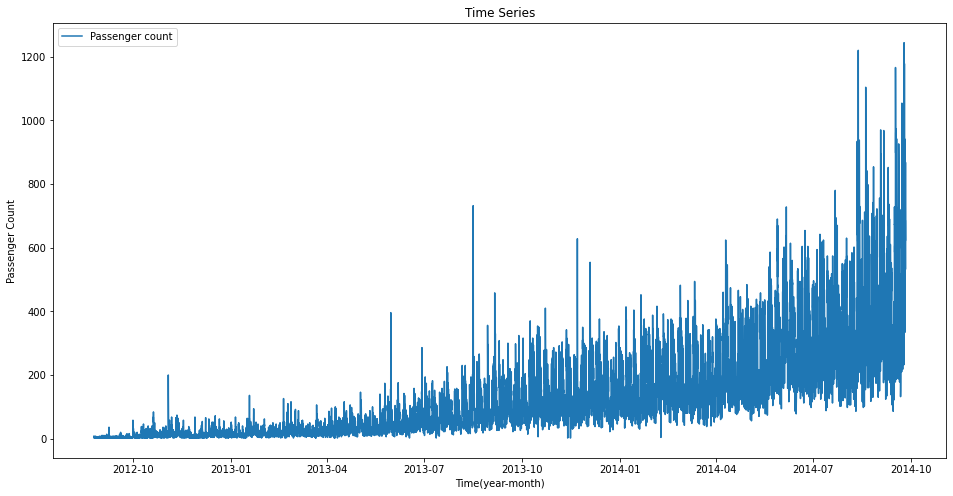

In [11]:
# Plotting time series
train.index = train['Datetime']       #indexing datetime to get time period on x axis
df = train.drop('ID', 1)              #dropping id column

ts = df['Count']
plt.figure(figsize = (16, 8))
plt.plot(ts, label = 'Passenger count')               #plot(y) : plots y using x as index array. So here datetime is on x axis
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger Count")
plt.legend(loc='best')

#### Exploratory Data Analysis

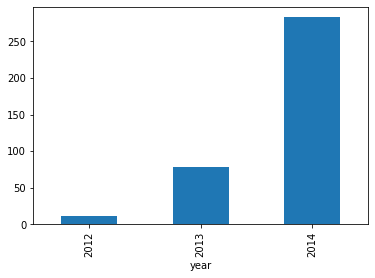

In [12]:
#first hypothesis is traffic will increase as the years pass by. 
# So let's look at yearly passenger count. 
train.groupby('year')['Count'].mean().plot.bar()

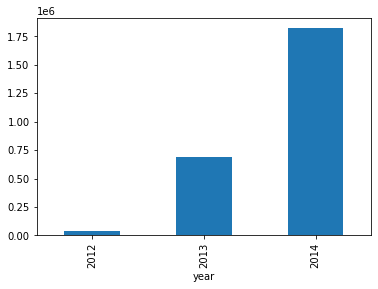

In [13]:
train.groupby('year')['Count'].sum().plot.bar()

There is an exponential growth in the traffic with respect to year which validates our hypothesis.

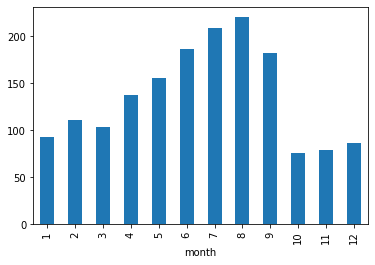

In [14]:
# Second hypothesis is about increase in traffic from May to October. So,let's see the relation between count and month
train.groupby('month')['Count'].mean().plot.bar()

Here we see a decrease in the mean of passenger count in last four months.This does not look right. Let's look at the monthly mean of each year separately. 

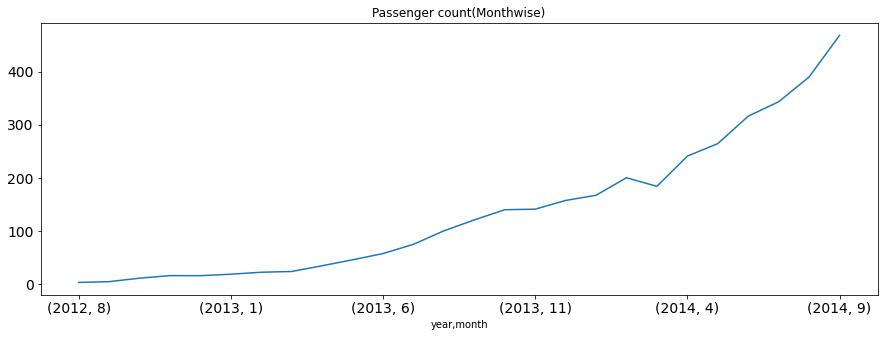

In [15]:
train.groupby(['year','month'])['Count'].mean().plot(figsize=(15,5),title="Passenger count(Monthwise)", fontsize=14)

We see that the months 10,11 and 12 are not present for the year 2014 and the mean value for these months in year 2012 is very less.Since there is an increasing trend in our time series,the mean value for rest of the months will be more because of their larger passenger counts in year 2014 and we will get smaller value for these 3 months.In the above line plot we can see an increasing trend in monthly passenger count and the growth is approximately exponential.

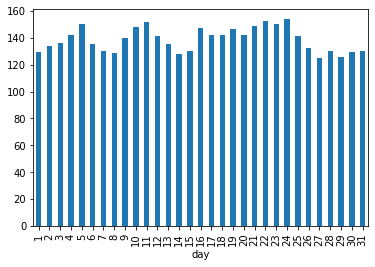

In [16]:
# let's look at daily mean passenger count
train.groupby('day')['Count'].mean().plot.bar()

We are not getting much insights from day wise count of the passengers. We also made a hypothesis that the traffic will be more during peak hours.So let's see the mean of hourly passenger count.

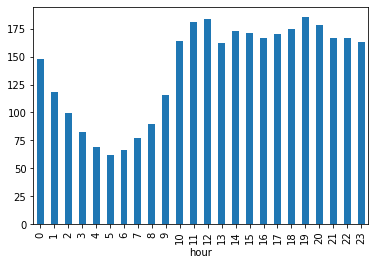

In [17]:
train.groupby("hour")['Count'].mean().plot.bar()

It can be inferred that the peak traffic is at 7 PM and then we see a decreasing trend till 5 AM.After that the passenger count starts increasing again and peaks again between 11 AM and 12 Noon.

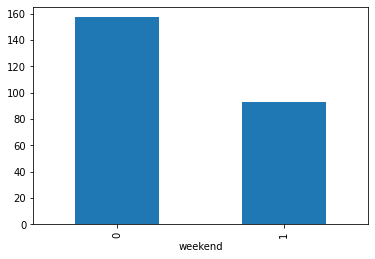

In [18]:
# Let's try to validate our hypothesis in which we assumed that the traffic will be more on weekdays.
train.groupby("weekend")['Count'].mean().plot.bar()

It can be inferred from the above plot that the traffic is more on weekdays as compared to weekends which validates our hypothesis. Now we will try to look at the day wise passenger count.

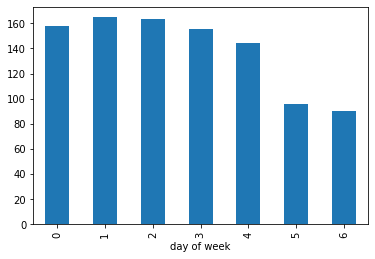

In [19]:
train.groupby("day of week")['Count'].mean().plot.bar()

From the above bar plot,we can infer that the passenger count is less for saturday and sunday as compared to the other days of the week.Now we will look at basic modeling techniques.Before that we will drop the ID variable as it has nothing to do with the passenger count.

In [20]:
train.drop('ID',1, inplace=True)

As we have seen that there is alot of noise in the hourly time series,we will aggregate the hourly time series to daily, weekly,and monthly time series to reduce the noise and make it more stable and hence would be easier for a model to learn.

In [21]:
train.Timestamp = pd.to_datetime(train.Datetime, format="%d-%m-%Y %H:%M")
train.index = train.Timestamp
#Hourly time series
hourly = train.resample('H').mean()         #Resampling generates a unique sampling distribution on the basis of actual data
#Converting to daily mean 
daily = train.resample('D').mean()
#Converting to weekly mean 
weekly = train.resample('W').mean()
#Converting to monthly mean 
monthly = train.resample('M').mean()

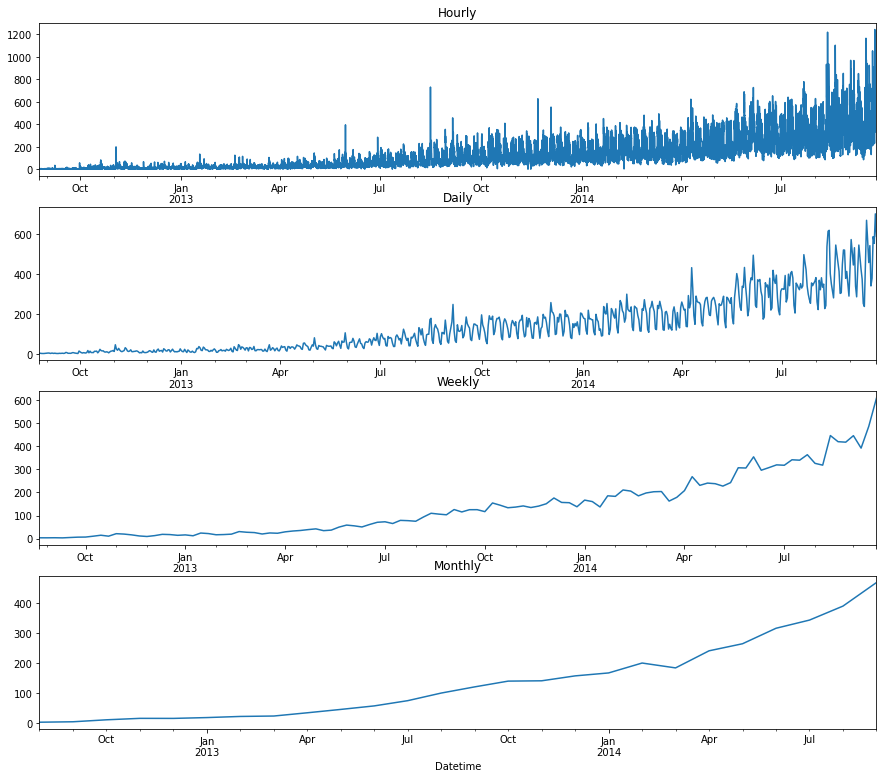

In [22]:
fig, axs = plt.subplots(4,1)
hourly.Count.plot(figsize=(15,13),title='Hourly', ax=axs[0], stacked=True)
daily.Count.plot(figsize=(15,13),title='Daily', ax=axs[1], stacked=True)
weekly.Count.plot(figsize=(15,13),title='Weekly', ax=axs[2], stacked=True)
monthly.Count.plot(figsize=(15,13),title='Monthly', ax=axs[3], stacked=True)
plt.show()

We can see that the time series is becoming more and more stable when we are aggregating it on daily, weekly and monthly basis.But it would be difficult to convert the monthly and weekly predictions to hourly predictions,as first we have to convert the monthly predictions to weekly, weekly to daily and daily to hourly predictions, which will become very expanded process. So,we will work on the daily time series.

In [23]:
test.Timestamp = pd.to_datetime(test.Datetime, format='%d-%m-%Y %H:%M')
test.index = test.Timestamp
#Converting to daily mean 
test = test.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime, format='%d-%m-%Y %H:%M')
train.index = train.Timestamp
#Converting to daily mean 
train = train.resample('D').mean()

In [24]:
# now we will divide train data into train and validation set
# we will take last 3 month data for validation and rest is for training
# starting date of dataset is 25/08/2012 and ending date is 25/09/2014
Train = train.loc['2012-08-25':'2014-06-24']
valid = train.loc['2014-06-25':'2014-09-25']

# ix supports both index and position based slicing (loc, iloc)
# loc is used for index, iloc is used for row position

Note : We cannot split dataset randomly beacause keeping order of data is important in time series. We cannot predict past data based on future data which will happen if we split dataset randomly.

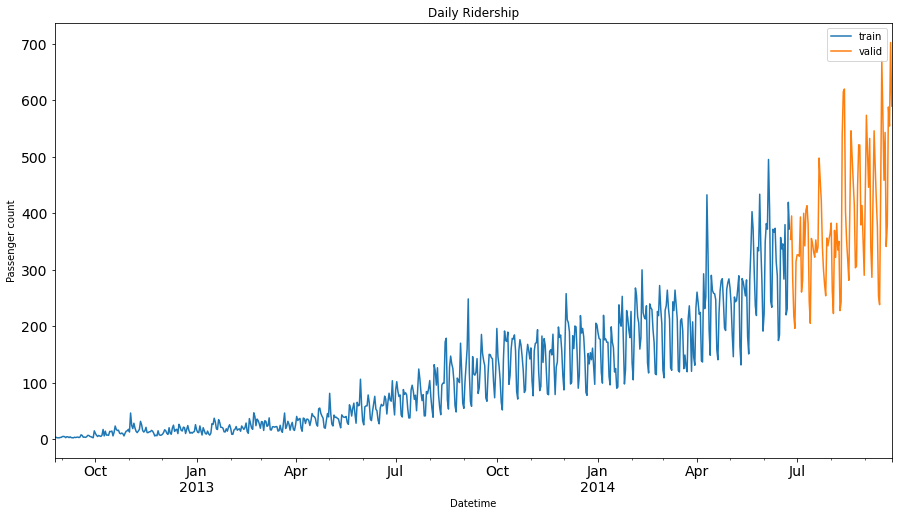

In [25]:
#visualizing splitted data
Train.Count.plot(figsize=(15,8),title='Daily Ridership', fontsize=14, label='train')
valid.Count.plot(figsize=(15,8),title='Daily Ridership', fontsize=14,label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc="best")
plt.show()

### Modeling Techniques

#### Naive Approach

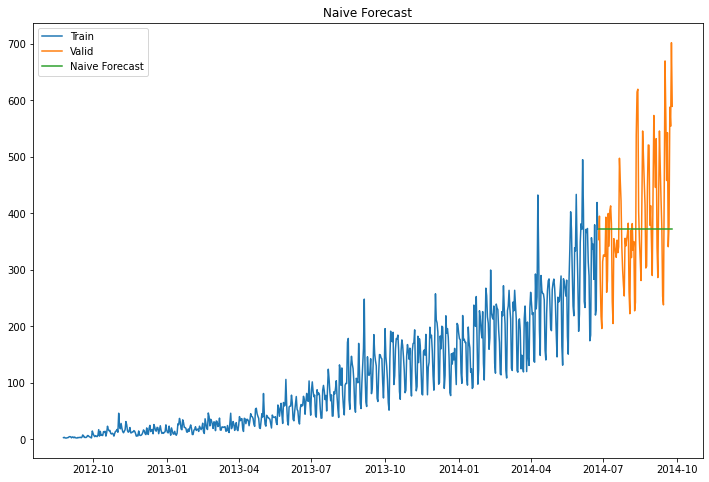

In [26]:
dd = np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1]      #to assign scaler to whole column
plt.figure(figsize=(12,8))
plt.plot(Train.index, Train['Count'], label="Train")
plt.plot(valid.index, valid['Count'], label='Valid')
plt.plot(y_hat.index, y_hat['naive'], label='Naive Forecast')
plt.legend(loc="best")
plt.title("Naive Forecast")
plt.show()

In [27]:
rms_naive = sqrt(mean_squared_error(valid.Count, y_hat.naive))
rms_naive

111.79050467496724

#### Moving Average
We took average of last 10, 20 and 50 observations and compared predictions.

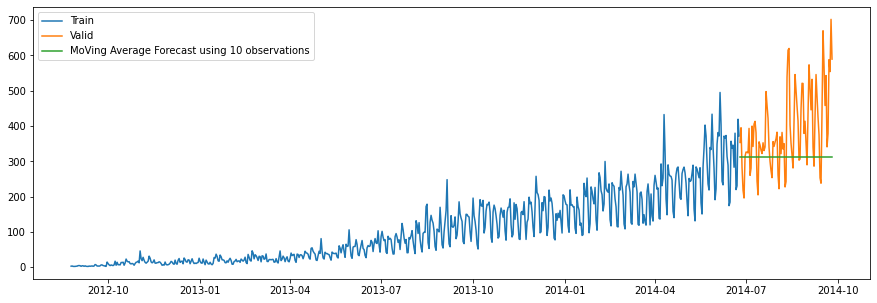

In [28]:
y_hat_avg = valid.copy () 
# rolling provides feature of rolling window function
# here rolling returns mean of last 10 observations for each value. hence first 10 values will be Nan
# iloc indicates last value from rolling that is mean of last 10 observations
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] 
# average of last 10 observations.
plt.figure(figsize= (15,5)) 
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label="MoVing Average Forecast using 10 observations")
plt.legend(loc='best') 
plt.show()

In [29]:
rms_10_avg = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast))
rms_10_avg

134.23733308950264

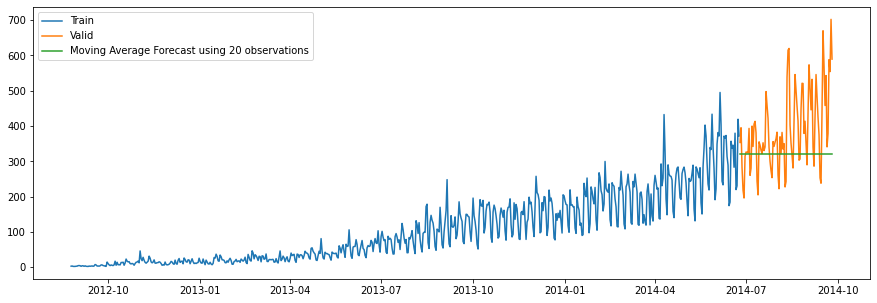

In [30]:
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] 
# average of last 20 observations.
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train')
plt.plot(valid["Count"], label="Valid")
plt.plot(y_hat_avg['moving_avg_forecast'], label= 'Moving Average Forecast using 20 observations')
plt.legend(loc= 'best') 
plt.show()

In [31]:
rms_20_avg = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast))
rms_20_avg

130.44984977550422

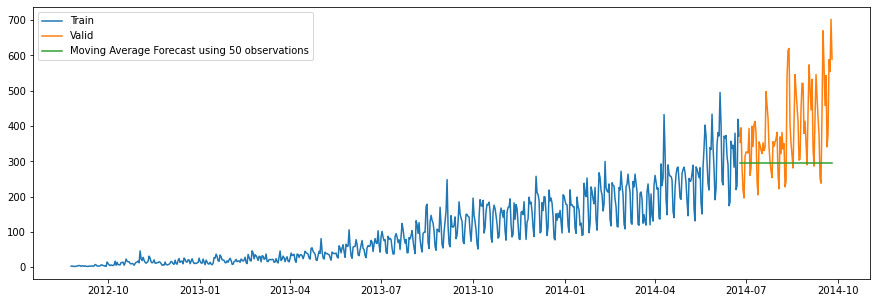

In [32]:
y_hat_avg = valid.copy() 
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] 
# average of last 50 observations.
plt.figure(figsize=( 15,5)) 
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label="Moving Average Forecast using 50 observations")
plt.legend(loc='best') 
plt.show()

In [33]:
rms_50_avg = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast))
rms_50_avg

144.19175679986802

We observed that predictions are getting weaker as we increase the number of observations.

#### Simple Exponential Smoothing

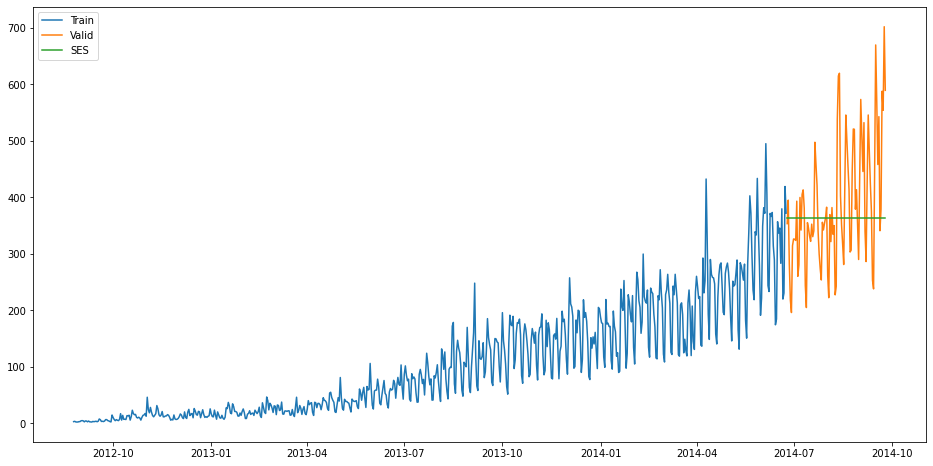

In [34]:
y_hat_exp = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6, optimized=False)
y_hat_exp['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_exp['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [35]:
rms_exp = sqrt(mean_squared_error(valid.Count, y_hat_exp.SES))
rms_exp

113.43708111884514

#### Holt's Linear Model
First of all we will visualize the trend, seasonality and errors in the series.

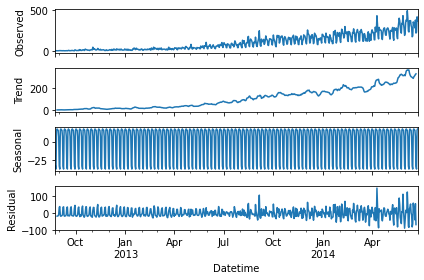

In [36]:
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

There is an increasing trend in the dataset. Now we will make a model based on the trend.

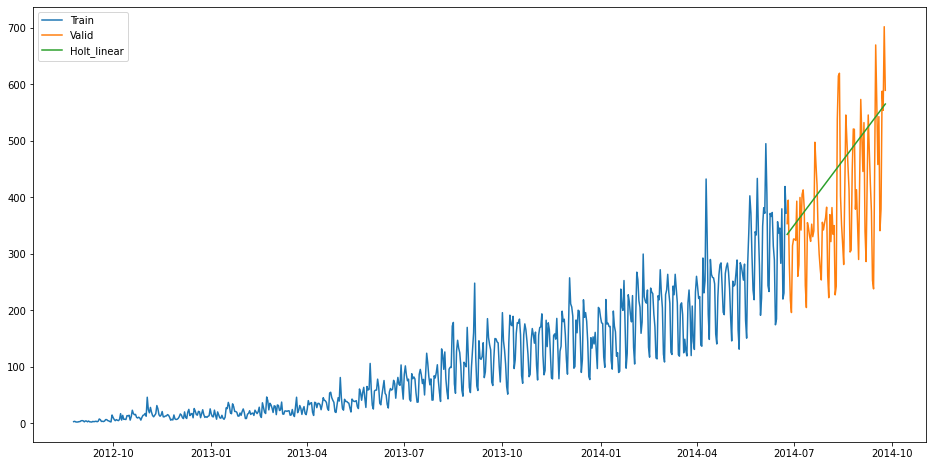

In [37]:
y_hat_holt = valid.copy()
fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level=0.3, smoothing_slope=0.1)
y_hat_holt['Holt_linear'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label="Train")
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_holt['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [38]:
rms_holt = sqrt(mean_squared_error(valid.Count, y_hat_holt.Holt_linear))
rms_holt

112.94278345314041

Let's make predictions on test data. We will make predictions based on daily time series and then will distribute that daily predictions to hourly predictions.

In [39]:
predict = fit1.forecast(len(test))
test['prediction'] = predict

Remember this predictions are daily basis. We will need to convert them into hourly basis. To do So we will first calculate the ratio of passenger count for each hour of everyday.Then we will find the average ratio of passenger count for every hour and we will get 24 ratios. Then to calculate the hourly predictions we will multiply the daily prediction with the hourly ratio.

In [40]:
#Calculating the hourly ratio of Count 
train_original['ratio'] = train_original['Count']/train_original['Count'].sum()
#Grouping the hourly ratio
temp = train_original.groupby(['hour'])['ratio'].sum()
#groupby to csv format
pd.DataFrame(temp, columns=['hour', 'ratio']).to_csv('groupby.csv')
temp2 = pd.read_csv('groupby.csv')
temp2.drop('hour.1', 1, inplace=True)
#merging test and test original on day month year
merge = pd.merge(test, test_original, on=('day', 'month', 'year'), how='left')
merge['hour'] = merge['hour_y']
merge.drop(['year', 'month', 'Datetime', 'hour_x', 'hour_y'], axis = 1, inplace=True)
#predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on='hour', how='left')
#converting ratio to original scale
prediction['Count'] = prediction['prediction'] * prediction['ratio'] * 24
prediction['ID'] = prediction['ID_y']
#let's drop all other features from the submission file and keep id and count only
submission_ts = prediction.drop(['ID_x', 'day', 'ID_y', 'prediction', 'hour', 'ratio'], axis=1)
 

In [41]:
submission_ts = submission_ts[['ID', 'Count']]

In [42]:
#converting final submission to csv format
submission_ts.to_csv('Holt_linear.csv', index=False)

from google.colab import files
files.download('Holt_linear.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Holt's Winter Model
The dataset which shows a similar pattern after fixed intervals of time period suffer from seasonality. The above mentioned model don't take into account the seasonality of the dataset while forecasting. Hence we need a method that takes into account both trend and seasonality to forecast future data. One such algorithm that we can use in such a scenario is Holt's Winter method. The idea behind Holt's winter is to apple exponential smoothing to the seasonal components in addition to level and trend.

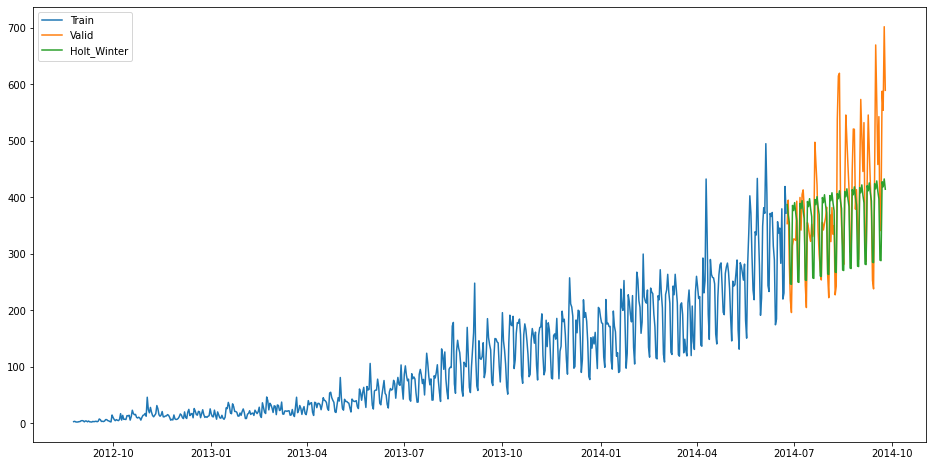

In [43]:
y_hat_holt_winter = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(Train['Count']), seasonal_periods=7, trend='add', seasonal="add",).fit()
y_hat_holt_winter['Holt_Winter'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label="Train")
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_holt_winter['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [44]:
rms_holt_winter = sqrt(mean_squared_error(valid.Count, y_hat_holt_winter.Holt_Winter))
rms_holt_winter

82.37571191747172

This method has reduced rmse value alot. Let's try forecasting test dataset. But it has produced rmse of 328.356 on leaderboard. The possible reason behind this may be that this model was not that good in predicting the trend of the time series but worked well on the seasonality part.

#### ARIMA Model

##### Stationarity Check

In [77]:

def test_stationarity(timeseries):
  #Determing rolling statistics 
  #rolmean = train_original.rolling(24).mean()
  #24 hours on each day 
  #rolstd = train_original.rolling(24).std()
  #plot rolling statistics 
  #plt.plot(timeseries, color='blue', label='Original')
  #plt.plot(rolmean, color='red', label='RollingMean')
  #plt.plot(rolstd, color='black', label='RollingStd')
  #plt.legend(loc='best')
  #plt.title('Rolling Mean & Standard Deviation')
  #plt.yticks([0, 200, 400, 600, 800, 1000, 1200])
  #plt.show()
  #PerformDickey-Fullertest:
  print('ResultsofDickey-FullerTest:')
  dftest = sm.tsa.stattools.adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['TestStatistic', 'p-value', '#LagsUsed', 'NumberofObservationsUsed'])
  for key, value in dftest[4].items():
    dfoutput['Critical Value(%s)'%key] = value
  print(dfoutput)

rcParams['figure.figsize'] = 15, 5
test_stationarity(train_original['Count'])


ResultsofDickey-FullerTest:
TestStatistic                  -4.456561
p-value                         0.000235
#LagsUsed                      45.000000
NumberofObservationsUsed    18242.000000
Critical Value(1%)             -3.430709
Critical Value(5%)             -2.861698
Critical Value(10%)            -2.566854
dtype: float64


As t statistics is less than critical value this shows that time series is stationary. but we can see an increasing trend in the data. So, first we will try to make data more stationary. For doing so we need to remove the trend and seasonality from the data.

##### Removing Trend

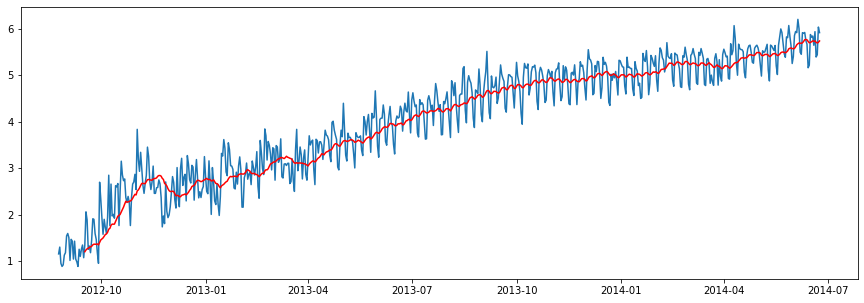

In [78]:
# using log transformation for removing trend
Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])
moving_avg = Train_log.rolling(24).mean()
plt.plot(Train_log)
plt.plot(moving_avg, color='red')
plt.show()

So we can observe an increasing trend. Now we will remove this increasing trend to make our time series stationary.

In [79]:
train_log_moving_avg_diff = Train_log - moving_avg

Since we took the average of 24 values, rolling mean is not defind for the first 23 values. So let's drop those null values

In [80]:
train_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(train_log_moving_avg_diff)

ResultsofDickey-FullerTest:
TestStatistic              -5.861646e+00
p-value                     3.399422e-07
#LagsUsed                   2.000000e+01
NumberofObservationsUsed    6.250000e+02
Critical Value(1%)         -3.440856e+00
Critical Value(5%)         -2.866175e+00
Critical Value(10%)        -2.569239e+00
dtype: float64


As we can see test statistics is smaller than critical value. We can be confident that the trend is almost removed. Now let's stabilize the mean of the time series which is also a requirement for a stationary time series. Differencing can help to make the series stable and eliminate the trend.

In [81]:
train_log_diff = Train_log - Train_log.shift(1)
test_stationarity(train_log_diff.dropna())

ResultsofDickey-FullerTest:
TestStatistic              -8.237568e+00
p-value                     5.834049e-13
#LagsUsed                   1.900000e+01
NumberofObservationsUsed    6.480000e+02
Critical Value(1%)         -3.440482e+00
Critical Value(5%)         -2.866011e+00
Critical Value(10%)        -2.569151e+00
dtype: float64


##### Removing Seasonality
Now we will decompose the time series into trend and seasonality and will get the residuals which is a random variation in series.

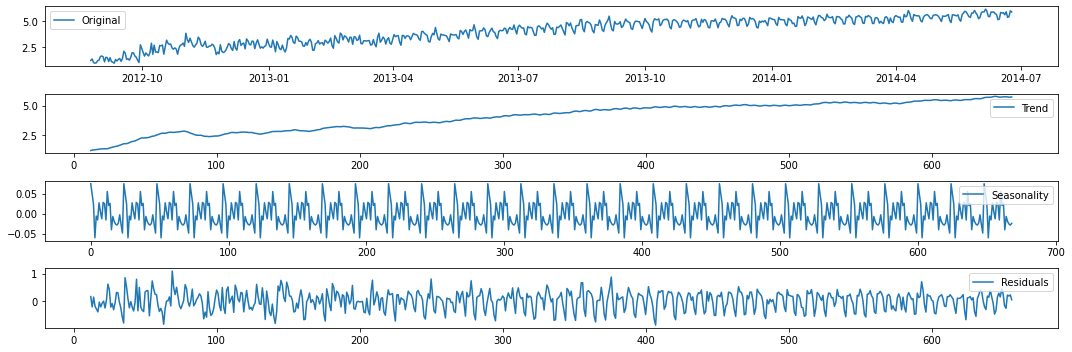

In [82]:
decomposition = sm.tsa.seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see the trend, residuals, seasonality clearly in above graph. Seasonality shows a constant trend in counter. Let's check stationarity of residuals.

In [84]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace=True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

ResultsofDickey-FullerTest:
TestStatistic              -7.822096e+00
p-value                     6.628321e-12
#LagsUsed                   2.000000e+01
NumberofObservationsUsed    6.240000e+02
Critical Value(1%)         -3.440873e+00
Critical Value(5%)         -2.866183e+00
Critical Value(10%)        -2.569243e+00
dtype: float64


It can be interpreted from the results that the residuals are stationary. Now we will forecast the time series using ARIMA model

##### Forecasting Using ARIMA Model
First we will fit the ARIMA model on our time series for that we have to find the optimized values for the p, d, q parameters. To find the optimized values of these parameters, we will use ACF(Autocorrelation Function) and PACF(Partial Autocorrelation Function) graph.

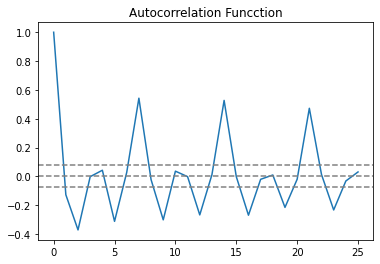

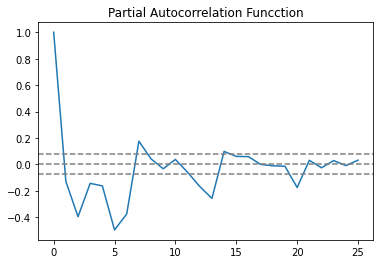

In [86]:
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Autocorrelation Funcction')
plt.show()
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Funcction')
plt.show()

p value is the lag value where the PACF chart crosses the upper confidence interval for the first time. It can be noticed that in this case p is 1.
q value is the lag value where ACF chart crosses the upper confidence interval for the first time. In this case q is 1. Now we will make ARIMA model. We will make AR and MA model separately and then combine them together.

###### AR Model
The autoregressive model specifies that the output variable depends linearly on its own previous values. 

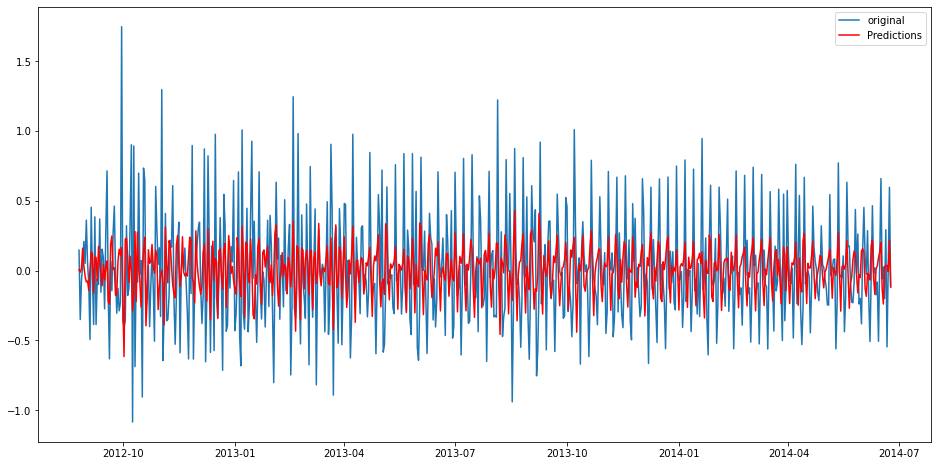

In [89]:
# order is (p,d,q)
model = ARIMA(Train_log, order=(2,1,0))    # here the q value is zero sice it is just AR model 
result_AR = model.fit(disp=-1)
plt.figure(figsize=(16,8))
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(result_AR.fittedvalues, color='red', label='Predictions')
plt.legend(loc='best')
plt.show()

Let's plot the validation curve for AR model. We have to change the scale of the model to the original scale. First step would be to store the predicted results as a separate series and observe it.

In [113]:
AR_predict = result_AR.predict(start='2014-06-25', end='2014-09-25')
AR_predict = AR_predict.cumsum().shift().fillna(0)
AR_predict1 = pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index=valid.index)

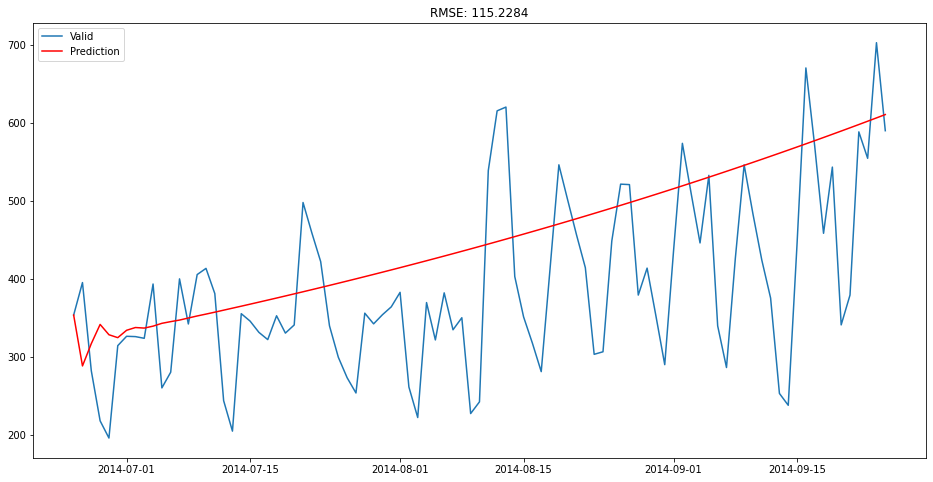

In [114]:
AR_predict1 = AR_predict1.add(AR_predict, fill_value=0)
AR_predict = np.exp(AR_predict1)
plt.figure(figsize=(16,8))
plt.plot(valid['Count'], label='Valid')
plt.plot(AR_predict, color='red', label='Prediction')
plt.legend(loc='best')
plt.title('RMSE: %.4f'%(np.sqrt(mean_squared_error(valid.Count, AR_predict))))
plt.show()

###### MA model
Let's build MA model now. The moving average model specifies that the output variable depends linearly on the current and various past values of a stochastic term.

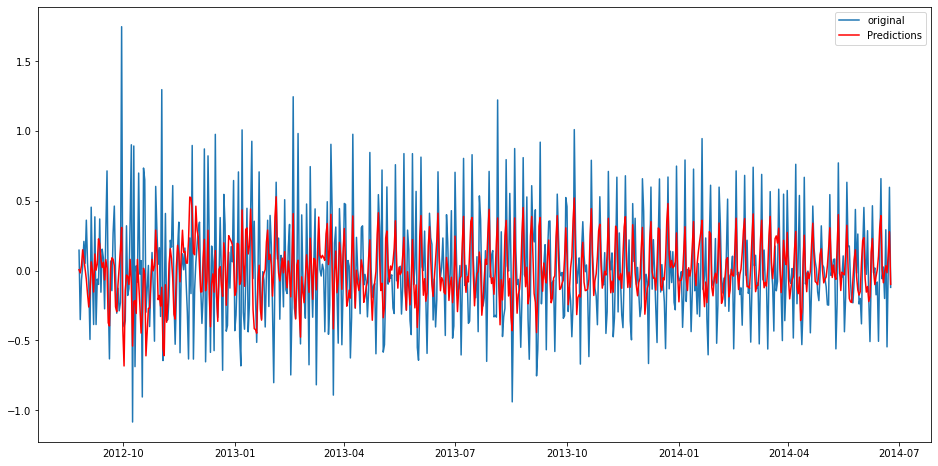

In [115]:
# order is (p,d,q)
model = ARIMA(Train_log, order=(0,1,2))    # here the p value is zero sice it is just MA model 
result_MA = model.fit(disp=-1)
plt.figure(figsize=(16,8))
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(result_MA.fittedvalues, color='red', label='Predictions')
plt.legend(loc='best')
plt.show()

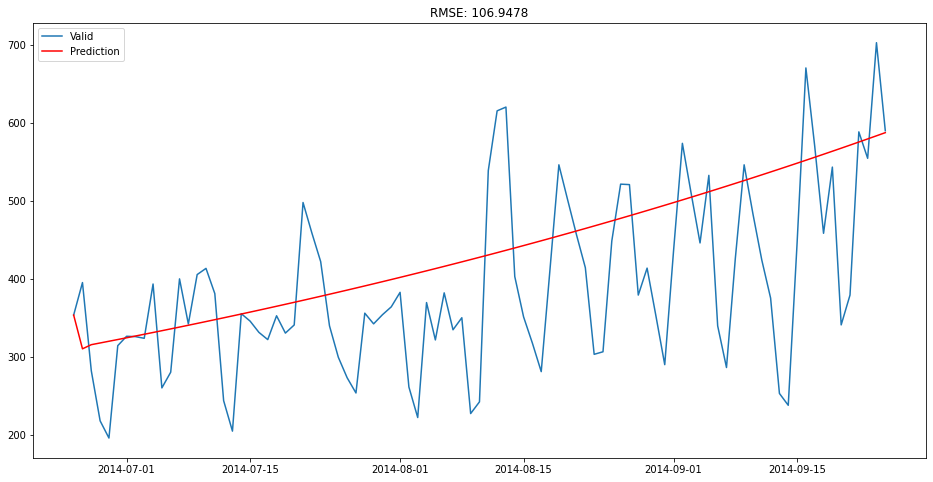

In [116]:
MA_predict = result_MA.predict(start='2014-06-25', end='2014-09-25')
MA_predict = MA_predict.cumsum().shift().fillna(0)
MA_predict1 = pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index=valid.index)

MA_predict1 = MA_predict1.add(MA_predict, fill_value=0)
MA_predict = np.exp(MA_predict1)
plt.figure(figsize=(16,8))
plt.plot(valid['Count'], label='Valid')
plt.plot(MA_predict, color='red', label='Prediction')
plt.legend(loc='best')
plt.title('RMSE: %.4f'%(np.sqrt(mean_squared_error(valid.Count, MA_predict))))
plt.show()

###### Combined Model
Let's combine these two model.

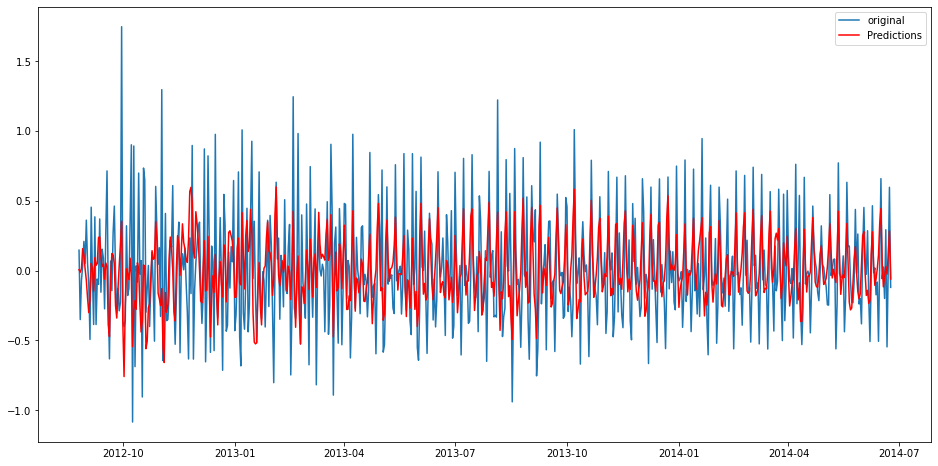

In [117]:
# order is (p,d,q)
model = ARIMA(Train_log, order=(2,1,2))
result_ARIMA = model.fit(disp=-1)
plt.figure(figsize=(16,8))
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(result_ARIMA.fittedvalues, color='red', label='Predictions')
plt.legend(loc='best')
plt.show()

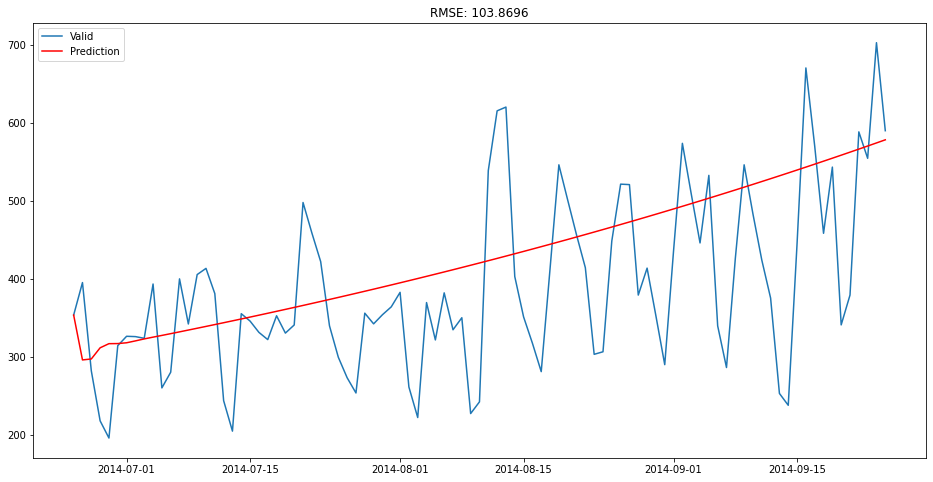

In [118]:
ARIMA_predict = result_ARIMA.predict(start='2014-06-25', end='2014-09-25')
ARIMA_predict = ARIMA_predict.cumsum().shift().fillna(0)
ARIMA_predict1 = pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index=valid.index)

ARIMA_predict1 = ARIMA_predict1.add(ARIMA_predict, fill_value=0)
ARIMA_predict = np.exp(ARIMA_predict1)
plt.figure(figsize=(16,8))
plt.plot(valid['Count'], label='Valid')
plt.plot(ARIMA_predict, color='red', label='Prediction')
plt.legend(loc='best')
plt.title('RMSE: %.4f'%(np.sqrt(mean_squared_error(valid.Count, ARIMA_predict))))
plt.show()

#### SARIMAX Model
SARIMAX model takes into account the seasonality of the time series.

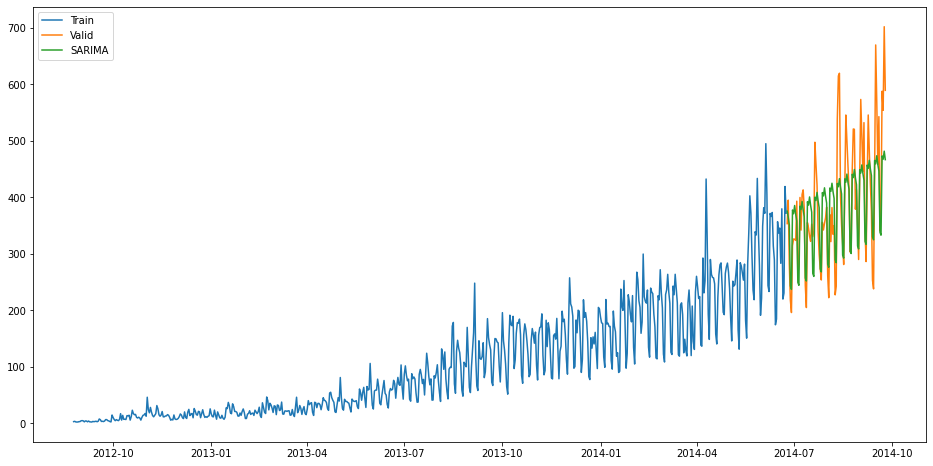

In [119]:
y_hat = valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2,1,4), seasonal_order=(0,1,1,7)).fit()
y_hat['SARIMA'] = fit1.predict(start='2014-06-25', end = '2014-09-25', dynamic=True)
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat['SARIMA'], label = 'SARIMA')
plt.legend(loc='best')
plt.show()

In [121]:
rmse_SARIMA = sqrt(mean_squared_error(valid.Count, y_hat.SARIMA))
rmse_SARIMA

69.7096906968534

In [122]:
test['prediction'] = y_hat["SARIMA"]
#merge test and test_original on day,  month, year
merge = pd.merge(test, test_original, on=('day', 'month', 'year'), how='left')
merge['hour'] = merge['hour_y']
merge.drop(['year', 'month', 'Datetime', 'hour_x', 'hour_y'], axis = 1, inplace=True)
#predicting by merging merge and temp2
prediction = pd.merge(merge, temp2, on='hour', how='left')
#converting ratio to original scale
prediction['Count'] = prediction['prediction'] * prediction['ratio'] * 24
prediction['ID'] = prediction['ID_y']
#let's drop all other features from the submission file and keep id and count only
submission_SARIMA = prediction.drop(['ID_x', 'day', 'ID_y', 'prediction', 'hour', 'ratio'], axis=1)
#converting to csv file
submission_ts = submission_ts[['ID', 'Count']]

submission_ts.to_csv('SARIMAX.csv', index=False)


In [123]:
# downloading file
from google.colab import files
files.download('SARIMAX.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>